In [268]:
import numpy as np
import pandas as pd
import scipy.stats

from tqdm import tqdm
import os
import pickle as pkl
import time
import nltk
from textblob import TextBlob
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import pipeline
import matplotlib.pyplot as plt
tqdm.pandas()
nltk.download('vader_lexicon')
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import accuracy_score, roc_auc_score
from scipy import stats as sts
import seaborn as sns

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ericsaikali/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# DATA PREPROCESSING

In [30]:
DATA_FOLDER = 'data/MovieSummaries/'
ADDITIONAL_FOLDER = 'data/AdditionalData/'

In [31]:
# reading a txt file and convert it to a dataframe
def read_txt(path):
    df = pd.read_csv(path, sep='\t', header=None)
    return df

In [141]:
# importing the data
plots = pd.read_csv(DATA_FOLDER + 'plot_summaries.txt', header=None, sep="\t")
movies = pd.read_csv(DATA_FOLDER + 'movie.metadata.tsv', header=None, sep="\t")
characters = pd.read_csv(DATA_FOLDER + 'character.metadata.tsv', header=None, sep="\t")
names = pd.read_csv(DATA_FOLDER + 'name.clusters.txt', header=None, sep="\t")
tvtropes = pd.read_csv(DATA_FOLDER + 'tvtropes.clusters.txt', header=None, sep="\t")

In [142]:
# renaming columns the plots dataframe
plots.columns = ['wikipedia_movie_id', 'plot']

In [145]:
movies

,0,1,2,3,4,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ..."


# RETRIEVE ENDINGS

In [6]:
# Sample synopsis
synopsis = plots.iloc[:, 1].loc[0]

In [7]:
def find_ending(plot, max_sentences=3):
    blob = TextBlob(plot)
    last_sentences = blob.sentences[-max_sentences:]  
    return " ".join([str(sentence) for sentence in last_sentences])

In [8]:
plots['endings'] = plots.iloc[:, 1].apply(lambda plot: find_ending(plot))
plots['endings']

0        Shlykov, a hard-working taxi driver and Lyosha...
1        However, before they can commit suicide, they ...
2        At Menon's funeral, Manapally Pavithran arrive...
3        Moran and Charley are arrested while the judge...
4        In October 1982, Lindy is found guilty and sen...
                               ...                        
42298    The story is about Reema , a young Muslim scho...
42299    Moved, Leo tells him they have. The assistant ...
42300    Now Parsons is creating instruments that are h...
42301    Mini does not recognize Rehman, who realises t...
42302    Mainwaring and his men become the pride of the...
Name: endings, Length: 42303, dtype: object

# SENTIMENT ANALYSIS

In [9]:
sia = SentimentIntensityAnalyzer()

In [10]:
def attribute_polar_sentiments(text):
    dico = sia.polarity_scores(text)
    return dico['neg'], dico['neu'], dico['pos'], dico['compound']


In [194]:
attribute_polar_sentiments("Then aymeric killed eric.")

(0.6, 0.4, 0.0, -0.6705)

In [11]:
emotion_pipeline = pipeline("text-classification", model="bhadresh-savani/distilbert-base-uncased-emotion", top_k=100)

In [12]:
def attribute_multi_sentiments(text):
    try:
        emotions = emotion_pipeline(text)[0]
        
        sorted_emotions = sorted(emotions, key=lambda x: x['label'])
    
        # Extract scores and put them in a tuple
        scores_tuple = tuple(res['score'] for res in sorted_emotions)
        return scores_tuple
    except:
        print(text)
        return (0,0,0,0,0,0)
    
    #emotion_map = {result['label']: result['score'] for result in emotions}
    #return emotion_map



In [13]:
prediction = emotion_pipeline("I am happy " )
attribute_multi_sentiments("I am happy")

(0.0002622490865178406,
 0.00014311514678411186,
 0.998437225818634,
 0.00045619261800311506,
 0.0005438445368781686,
 0.00015750866441521794)

In [14]:
sentiments = plots['endings'].apply(lambda end: attribute_polar_sentiments(end))
sentiments_df = pd.DataFrame(sentiments.tolist(), columns=['ending_negativity', 'ending_neutrality', 'ending_positivity', 'ending_compound_sentiment'])
plots = plots.join(sentiments_df)
plots

,wikipedia_movie_id,plot,endings,ending_negativity,ending_neutrality,ending_positivity,ending_compound_sentiment
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...","Shlykov, a hard-working taxi driver and Lyosha...",0.093,0.812,0.095,0.0083
1,31186339,The nation of Panem consists of a wealthy Capi...,"However, before they can commit suicide, they ...",0.171,0.753,0.077,-0.7269
2,20663735,Poovalli Induchoodan is sentenced for six yea...,"At Menon's funeral, Manapally Pavithran arrive...",0.187,0.692,0.122,-0.5719
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",Moran and Charley are arrested while the judge...,0.078,0.791,0.132,0.7096
4,595909,Seventh-day Adventist Church pastor Michael Ch...,"In October 1982, Lindy is found guilty and sen...",0.144,0.843,0.013,-0.9042
...,...,...,...,...,...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho...","The story is about Reema , a young Muslim scho...",0.066,0.843,0.091,0.2732
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look...","Moved, Leo tells him they have. The assistant ...",0.000,0.652,0.348,0.9231
42300,35102018,American Luthier focuses on Randy Parsons’ tra...,Now Parsons is creating instruments that are h...,0.000,0.746,0.254,0.9686
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...","Mini does not recognize Rehman, who realises t...",0.034,0.883,0.083,0.4215


In [15]:
#sentiments = plots['endings'].progress_apply(lambda end: attribute_multi_sentiments(end))

In [16]:
#with open(f'{ADDITIONAL_FOLDER}ending_sentiments.pkl', 'wb') as f:
#    pkl.dump(sentiments, f)

with open(f'{ADDITIONAL_FOLDER}ending_sentiments.pkl', 'rb') as f:
    sentiments = pkl.load(f)

In [17]:
sentiments_df = pd.DataFrame(sentiments.tolist(), columns=['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'])
plots = plots.join(sentiments_df)
plots

,wikipedia_movie_id,plot,endings,ending_negativity,ending_neutrality,ending_positivity,ending_compound_sentiment,anger,fear,joy,love,sadness,surprise
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...","Shlykov, a hard-working taxi driver and Lyosha...",0.093,0.812,0.095,0.0083,0.005651,0.620628,0.003627,0.001354,0.003469,0.365272
1,31186339,The nation of Panem consists of a wealthy Capi...,"However, before they can commit suicide, they ...",0.171,0.753,0.077,-0.7269,0.862967,0.072434,0.050531,0.001587,0.011251,0.001230
2,20663735,Poovalli Induchoodan is sentenced for six yea...,"At Menon's funeral, Manapally Pavithran arrive...",0.187,0.692,0.122,-0.5719,0.024590,0.005117,0.934492,0.004668,0.030487,0.000646
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",Moran and Charley are arrested while the judge...,0.078,0.791,0.132,0.7096,0.020590,0.004994,0.965741,0.001478,0.006511,0.000685
4,595909,Seventh-day Adventist Church pastor Michael Ch...,"In October 1982, Lindy is found guilty and sen...",0.144,0.843,0.013,-0.9042,0.144775,0.768390,0.057049,0.002182,0.023313,0.004291
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho...","The story is about Reema , a young Muslim scho...",0.066,0.843,0.091,0.2732,0.016801,0.089359,0.008805,0.025031,0.857494,0.002510
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look...","Moved, Leo tells him they have. The assistant ...",0.000,0.652,0.348,0.9231,0.000681,0.000264,0.997107,0.000565,0.000669,0.000713
42300,35102018,American Luthier focuses on Randy Parsons’ tra...,Now Parsons is creating instruments that are h...,0.000,0.746,0.254,0.9686,0.000996,0.000311,0.995864,0.001760,0.000627,0.000443
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...","Mini does not recognize Rehman, who realises t...",0.034,0.883,0.083,0.4215,0.046122,0.017547,0.187119,0.003798,0.743204,0.002210


In [155]:
with open(f'{ADDITIONAL_FOLDER}plots_with_ending_sentiments.pkl', 'rb') as f:
    plots = pkl.load(f)
plots

,wikipedia_movie_id,plot,endings,ending_negativity,ending_neutrality,ending_positivity,ending_compound_sentiment,anger,fear,joy,love,sadness,surprise
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...","Shlykov, a hard-working taxi driver and Lyosha...",0.093,0.812,0.095,0.0083,0.005651,0.620628,0.003627,0.001354,0.003469,0.365272
1,31186339,The nation of Panem consists of a wealthy Capi...,"However, before they can commit suicide, they ...",0.171,0.753,0.077,-0.7269,0.862967,0.072434,0.050531,0.001587,0.011251,0.001230
2,20663735,Poovalli Induchoodan is sentenced for six yea...,"At Menon's funeral, Manapally Pavithran arrive...",0.187,0.692,0.122,-0.5719,0.024590,0.005117,0.934492,0.004668,0.030487,0.000646
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",Moran and Charley are arrested while the judge...,0.078,0.791,0.132,0.7096,0.020590,0.004994,0.965741,0.001478,0.006511,0.000685
4,595909,Seventh-day Adventist Church pastor Michael Ch...,"In October 1982, Lindy is found guilty and sen...",0.144,0.843,0.013,-0.9042,0.144775,0.768390,0.057049,0.002182,0.023313,0.004291
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho...","The story is about Reema , a young Muslim scho...",0.066,0.843,0.091,0.2732,0.016801,0.089359,0.008805,0.025031,0.857494,0.002510
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look...","Moved, Leo tells him they have. The assistant ...",0.000,0.652,0.348,0.9231,0.000681,0.000264,0.997107,0.000565,0.000669,0.000713
42300,35102018,American Luthier focuses on Randy Parsons’ tra...,Now Parsons is creating instruments that are h...,0.000,0.746,0.254,0.9686,0.000996,0.000311,0.995864,0.001760,0.000627,0.000443
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...","Mini does not recognize Rehman, who realises t...",0.034,0.883,0.083,0.4215,0.046122,0.017547,0.187119,0.003798,0.743204,0.002210


# ANALYSIS

## SENTIMENTS ONLY ANALYSIS

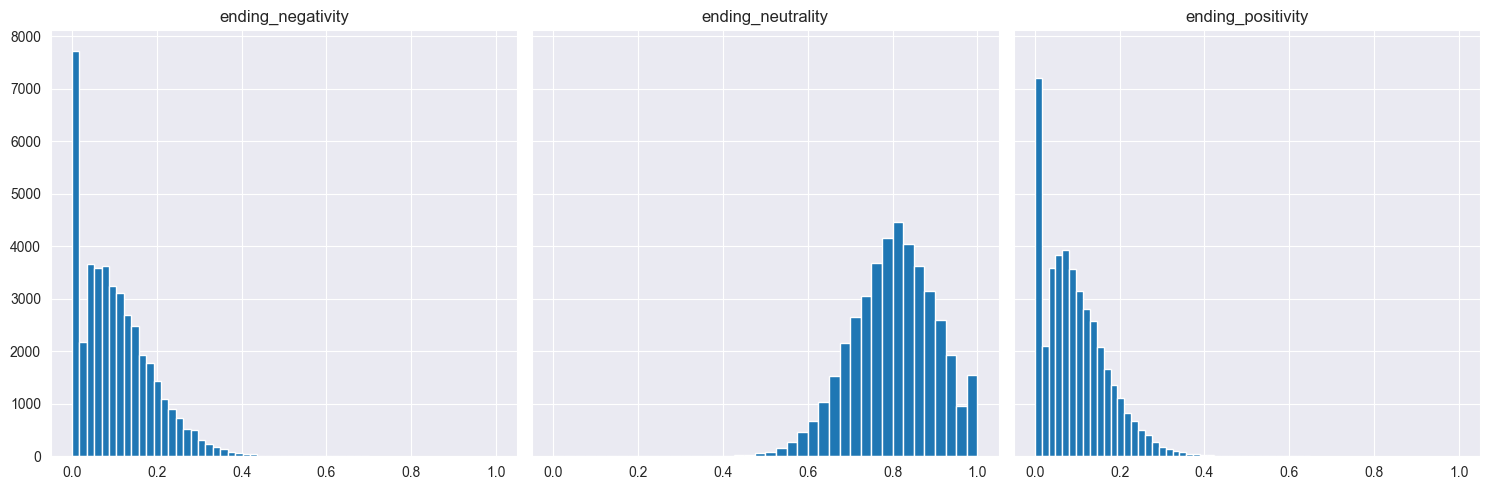

In [18]:
N_ROW = 1
N_COL = 3
fig, axs = plt.subplots(N_ROW, N_COL, figsize=(15, 5), sharey=True,sharex=True)

# Plotting histograms
for idx, col in enumerate(['ending_negativity', 'ending_neutrality', 'ending_positivity']):
    axs[idx].hist(plots[col], bins=40, label=col,)
    axs[idx].set_title(col)

plt.tight_layout()
plt.show()

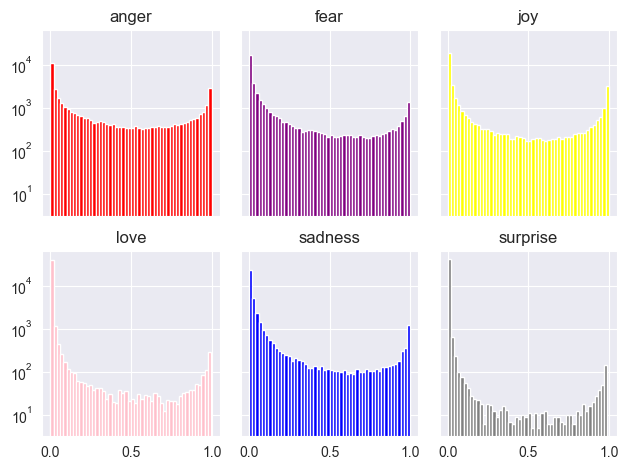

In [25]:
def hist_multi_sentiments(movie_plots,bins=50, ):
    N_ROW = 2
    N_COL = 3
    fig, axs = plt.subplots(N_ROW, N_COL, sharey=True, sharex=True)
    colors = ['red', 'purple', 'yellow', 'pink', 'blue', 'gray']
    for idx, col in enumerate(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']):
        axs[idx//N_COL, idx % N_COL].hist(movie_plots[col], bins=bins, label=col, color=colors[idx])
        axs[idx//N_COL, idx % N_COL].set_yscale('log')
        axs[idx//N_COL, idx % N_COL].set_title(col)
        
    plt.tight_layout()
hist_multi_sentiments(plots)

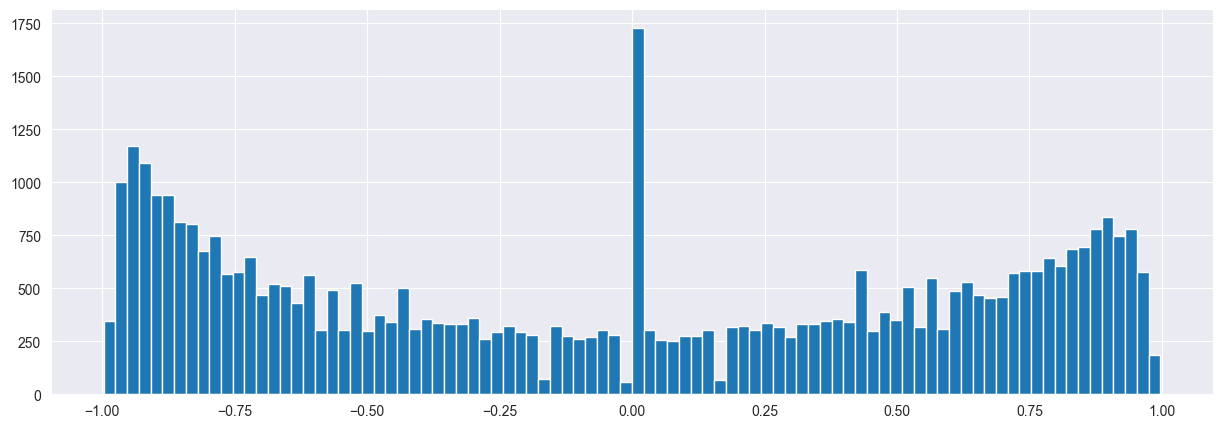

In [20]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.hist(plots['ending_compound_sentiment'],bins=90)
plt.show()


In [200]:
plots[(plots['ending_compound_sentiment'] <= -0.98) ].iloc[0].endings

'Head Thief takes the gun from her and shoots her in the head as Isa watches in horror. Young Thief comes up from the basement, and Head Thief kills him with one shot. Isa falls to her knees and stares at her mother in shock while Head Thief stabs her repeatedly in the stomach.'

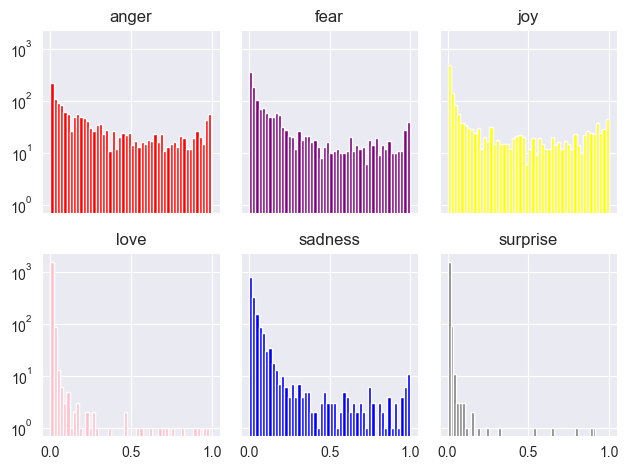

In [26]:
film_with_compound_zero = plots[(plots['ending_compound_sentiment'] == 0) ]
hist_multi_sentiments(film_with_compound_zero)

In [27]:
plots.columns

Index(['wikipedia_movie_id', 'plot', 'endings', 'ending_negativity',
       'ending_neutrality', 'ending_positivity', 'ending_compound_sentiment',
       'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'],
      dtype='object')

## MOVIE SCORE AND PROCESSING

In [152]:
with open(f'{ADDITIONAL_FOLDER}movie_scored_thresh_75.pkl',"rb") as f:
    movies = pkl.load(f)
movies 

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,languages,countries,genres,budget,...,correlation_factor,adjusted_revenue,adjusted_budget,adjusted_gross_domestic,adjusted_opening_weekend,BORC,RC,movie_score,Good Movie,Generic Genre
8110,2466773,/m/07g1sm,The Godfather,1972-03-15,2.685000e+08,177.0,"{""/m/04h9h"": ""Latin Language"", ""/m/02bjrlw"": ""...","{""/m/09c7w0"": ""United States of America""}","[Crime Fiction, Gangster Film, Crime Drama, Fa...",6000000.0,...,5.488629,1.473697e+09,3.293178e+07,7.485452e+08,1.659723e+06,0.930359,0.987805,95.908194,1,"[Crime, Drama, Family, Period piece]"
17595,174251,/m/017jd9,The Lord of the Rings: The Return of the King,2003-12-17,1.119930e+09,250.0,"{""/m/05p2d"": ""Old English language"", ""/m/02h40...","{""/m/09c7w0"": ""United States of America"", ""/m/...","[Fantasy Adventure, Adventure, Epic, Action/Ad...",94000000.0,...,1.246866,1.396402e+09,1.172054e+08,4.730948e+08,9.055949e+07,0.927864,0.963415,94.563911,1,"[Action, Adventure, Drama, Fantasy]"
8476,4276475,/m/0btpm6,The Dark Knight,2008-07-16,1.004558e+09,153.0,"{""/m/0653m"": ""Standard Mandarin"", ""/m/02h40lc""...","{""/m/09c7w0"": ""United States of America"", ""/m/...","[Crime Fiction, Thriller, Superhero movie, Cri...",185000000.0,...,1.066249,1.071109e+09,1.972560e+08,5.704292e+08,1.689060e+08,0.915580,0.963415,93.949723,1,"[Action, Adventure, Crime, Drama, Thriller]"
4837,4588970,/m/0cbckv,Anchorhead Story of Star Wars,1977-01-01 00:00:00,7.753980e+08,NaN,{},{},[],11000000.0,...,3.787533,2.936845e+09,4.166286e+07,1.746047e+09,5.887625e+06,0.962298,0.914634,93.846619,1,[]
17567,52549,/m/0dtfn,Star Wars Episode IV: A New Hope,1977-05-25,7.753980e+08,122.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Science Fiction, Adventure, Fantasy, Coming o...",11000000.0,...,3.787533,2.936845e+09,4.166286e+07,1.746047e+09,5.887625e+06,0.962298,0.914634,93.846619,1,"[Action, Adventure, Family, Fantasy, Science F..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11080,22031391,/m/05pbc0k,Mega Shark Vs. Giant Octopus,2009-05-26,7.220000e+02,90.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Science Fiction, Action, Horror, Sci-Fi Horror]",NaN,...,1.070531,7.729232e+02,NaN,NaN,NaN,0.260559,0.170732,21.564511,0,"[Action, Horror, Science Fiction]"
433,33323067,/m/06m9kx,Robotropolis,2011-09-02,1.180000e+02,80.0,{},{},"[Science Fiction, Action, Adventure]",NaN,...,1.021000,1.204780e+02,NaN,NaN,NaN,0.174466,0.243902,20.918441,0,"[Action, Adventure, Science Fiction]"
17541,33528878,/m/0hgqtr_,7 Lives,2011-10-07,5.100000e+01,90.0,{},"{""/m/07ssc"": ""United Kingdom""}","[Thriller, Fantasy]",2500.0,...,1.021000,5.207100e+01,2.552500e+03,NaN,NaN,0.135612,0.280488,20.804988,0,"[Fantasy, Thriller]"
9280,24873771,/m/03y8ltv,Thiruthani,2008,3.123000e+03,1440.0,"{""/m/07c9s"": ""Tamil Language""}","{""/m/03rk0"": ""India""}",[Action],NaN,...,1.066249,3.329894e+03,NaN,NaN,NaN,0.328207,0.073171,20.068884,0,[Action]


In [156]:
movies_and_plots = pd.merge(movies, plots, how='left', on='wikipedia_movie_id')
movies_and_plots

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,languages,countries,genres,budget,...,ending_negativity,ending_neutrality,ending_positivity,ending_compound_sentiment,anger,fear,joy,love,sadness,surprise
0,2466773,/m/07g1sm,The Godfather,1972-03-15,2.685000e+08,177.0,"{""/m/04h9h"": ""Latin Language"", ""/m/02bjrlw"": ""...","{""/m/09c7w0"": ""United States of America""}","[Crime Fiction, Gangster Film, Crime Drama, Fa...",6000000.0,...,0.323,0.634,0.043,-0.9325,0.625382,0.361798,0.005108,0.001051,0.005107,0.001554
1,174251,/m/017jd9,The Lord of the Rings: The Return of the King,2003-12-17,1.119930e+09,250.0,"{""/m/05p2d"": ""Old English language"", ""/m/02h40...","{""/m/09c7w0"": ""United States of America"", ""/m/...","[Fantasy Adventure, Adventure, Epic, Action/Ad...",94000000.0,...,0.000,0.860,0.140,0.9042,0.004856,0.001271,0.983792,0.007420,0.002239,0.000421
2,4276475,/m/0btpm6,The Dark Knight,2008-07-16,1.004558e+09,153.0,"{""/m/0653m"": ""Standard Mandarin"", ""/m/02h40lc""...","{""/m/09c7w0"": ""United States of America"", ""/m/...","[Crime Fiction, Thriller, Superhero movie, Cri...",185000000.0,...,0.134,0.715,0.151,-0.1779,0.531842,0.265491,0.125291,0.007958,0.066069,0.003349
3,4588970,/m/0cbckv,Anchorhead Story of Star Wars,1977-01-01 00:00:00,7.753980e+08,NaN,{},{},[],11000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,52549,/m/0dtfn,Star Wars Episode IV: A New Hope,1977-05-25,7.753980e+08,122.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Science Fiction, Adventure, Fantasy, Coming o...",11000000.0,...,0.286,0.564,0.150,-0.8674,0.057410,0.015148,0.908041,0.005745,0.009691,0.003965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17759,22031391,/m/05pbc0k,Mega Shark Vs. Giant Octopus,2009-05-26,7.220000e+02,90.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Science Fiction, Action, Horror, Sci-Fi Horror]",NaN,...,0.161,0.787,0.053,-0.7717,0.004610,0.984742,0.004200,0.000689,0.001851,0.003908
17760,33323067,/m/06m9kx,Robotropolis,2011-09-02,1.180000e+02,80.0,{},{},"[Science Fiction, Action, Adventure]",NaN,...,0.079,0.921,0.000,-0.5023,0.787283,0.194970,0.005897,0.000848,0.009246,0.001756
17761,33528878,/m/0hgqtr_,7 Lives,2011-10-07,5.100000e+01,90.0,{},"{""/m/07ssc"": ""United Kingdom""}","[Thriller, Fantasy]",2500.0,...,0.097,0.856,0.047,-0.6124,0.107309,0.865451,0.001683,0.000560,0.023573,0.001424
17762,24873771,/m/03y8ltv,Thiruthani,2008,3.123000e+03,1440.0,"{""/m/07c9s"": ""Tamil Language""}","{""/m/03rk0"": ""India""}",[Action],NaN,...,0.292,0.708,0.000,-0.9460,0.993431,0.003658,0.000755,0.000279,0.001542,0.000335


## ANALYSIS

In [157]:
percentage = movies_and_plots.endings.isna().sum() / len(movies_and_plots) * 100
print(f"Movies without a given plot : {percentage:.2f}%")

Movies without a given plot : 20.87%


In [158]:
movies_with_plots = movies_and_plots[~movies_and_plots.endings.isna()]
movies_with_plots

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,languages,countries,genres,budget,...,ending_negativity,ending_neutrality,ending_positivity,ending_compound_sentiment,anger,fear,joy,love,sadness,surprise
0,2466773,/m/07g1sm,The Godfather,1972-03-15,2.685000e+08,177.0,"{""/m/04h9h"": ""Latin Language"", ""/m/02bjrlw"": ""...","{""/m/09c7w0"": ""United States of America""}","[Crime Fiction, Gangster Film, Crime Drama, Fa...",6000000.0,...,0.323,0.634,0.043,-0.9325,0.625382,0.361798,0.005108,0.001051,0.005107,0.001554
1,174251,/m/017jd9,The Lord of the Rings: The Return of the King,2003-12-17,1.119930e+09,250.0,"{""/m/05p2d"": ""Old English language"", ""/m/02h40...","{""/m/09c7w0"": ""United States of America"", ""/m/...","[Fantasy Adventure, Adventure, Epic, Action/Ad...",94000000.0,...,0.000,0.860,0.140,0.9042,0.004856,0.001271,0.983792,0.007420,0.002239,0.000421
2,4276475,/m/0btpm6,The Dark Knight,2008-07-16,1.004558e+09,153.0,"{""/m/0653m"": ""Standard Mandarin"", ""/m/02h40lc""...","{""/m/09c7w0"": ""United States of America"", ""/m/...","[Crime Fiction, Thriller, Superhero movie, Cri...",185000000.0,...,0.134,0.715,0.151,-0.1779,0.531842,0.265491,0.125291,0.007958,0.066069,0.003349
4,52549,/m/0dtfn,Star Wars Episode IV: A New Hope,1977-05-25,7.753980e+08,122.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Science Fiction, Adventure, Fantasy, Coming o...",11000000.0,...,0.286,0.564,0.150,-0.8674,0.057410,0.015148,0.908041,0.005745,0.009691,0.003965
5,73875,/m/0jsf6,The Godfather Part II,1974-12-12,1.930000e+08,200.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/09c7w0"": ""United States of America""}","[Crime Fiction, Gangster Film, Drama, Crime Dr...",13000000.0,...,0.153,0.766,0.081,-0.4678,0.990646,0.007299,0.000638,0.000344,0.000783,0.000291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17759,22031391,/m/05pbc0k,Mega Shark Vs. Giant Octopus,2009-05-26,7.220000e+02,90.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Science Fiction, Action, Horror, Sci-Fi Horror]",NaN,...,0.161,0.787,0.053,-0.7717,0.004610,0.984742,0.004200,0.000689,0.001851,0.003908
17760,33323067,/m/06m9kx,Robotropolis,2011-09-02,1.180000e+02,80.0,{},{},"[Science Fiction, Action, Adventure]",NaN,...,0.079,0.921,0.000,-0.5023,0.787283,0.194970,0.005897,0.000848,0.009246,0.001756
17761,33528878,/m/0hgqtr_,7 Lives,2011-10-07,5.100000e+01,90.0,{},"{""/m/07ssc"": ""United Kingdom""}","[Thriller, Fantasy]",2500.0,...,0.097,0.856,0.047,-0.6124,0.107309,0.865451,0.001683,0.000560,0.023573,0.001424
17762,24873771,/m/03y8ltv,Thiruthani,2008,3.123000e+03,1440.0,"{""/m/07c9s"": ""Tamil Language""}","{""/m/03rk0"": ""India""}",[Action],NaN,...,0.292,0.708,0.000,-0.9460,0.993431,0.003658,0.000755,0.000279,0.001542,0.000335


In [159]:
X = movies_with_plots[['ending_negativity', 'ending_positivity', 'anger', 'fear', 'joy', 'love', 'sadness', 'surprise']].to_numpy()
y = movies_with_plots['movie_score'].to_numpy()


In [160]:
mutual_info = mutual_info_regression(X, y.reshape(-1,1))

/Users/ericsaikali/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/ada-2023-project-dataexplorers/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Which feeling distribution has the highest movie score ?
Do feeling has a significant correlation with movie score ?

In [161]:
mutual_info

array([0.01372592, 0.00107553, 0.00789364, 0.        , 0.01208806,
       0.01390483, 0.01581843, 0.        ])

In [162]:
x = movies_with_plots['ending_compound_sentiment'].to_numpy()
mutual_info = mutual_info_regression(y.reshape(-1,1), x.reshape(-1,1))
mutual_info

/Users/ericsaikali/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/ada-2023-project-dataexplorers/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0])

This does not sound promissing, however, someone that wants to watch a horror movies might not want the movie to end with a love story...
To improve the naive analysis, let's compare using the genres.

In [168]:
exploded_df = movies_and_plots.explode('Generic Genre')
dummies = pd.get_dummies(exploded_df['Generic Genre'], dtype=int)
combined_df = pd.concat([exploded_df, dummies], axis=1)
genres_cols = list(dummies.columns.values)
genres_cols.append('wikipedia_movie_id')
one_hot_encoded_genres = combined_df[genres_cols].groupby('wikipedia_movie_id').sum()
one_hot_encoded_genres

,Action,Action,Adventure,Adventure,Animation,Animation,Comedy,Comedy,Crime,Crime,...,Romance,Romance,Science Fiction,Science Fiction,Sport,Sport,Thriller,Thriller,War film,War film
wikipedia_movie_id,,,,,,,,,,,,,,,,,,,,,
3217,6,1,6,1,0,0,6,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3333,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,1
3746,0,0,0,0,0,0,0,0,4,1,...,0,0,4,1,0,0,4,1,0,0
3837,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3947,0,0,0,0,0,0,0,0,2,1,...,0,0,0,0,0,0,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37174696,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37210334,0,0,0,0,0,0,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
37241569,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [164]:
movies_and_plots = pd.merge(movies_and_plots, one_hot_encoded_genres, on='wikipedia_movie_id')
movies_with_plots = movies_and_plots[~movies_and_plots.endings.isna()]

In [165]:
movies_and_plots

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,languages,countries,genres,budget,...,Family,Fantasy,Horror,Musical,Period piece,Romance,Science Fiction,Sport,Thriller,War film
0,2466773,/m/07g1sm,The Godfather,1972-03-15,2.685000e+08,177.0,"{""/m/04h9h"": ""Latin Language"", ""/m/02bjrlw"": ""...","{""/m/09c7w0"": ""United States of America""}","[Crime Fiction, Gangster Film, Crime Drama, Fa...",6000000.0,...,1,0,0,0,1,0,0,0,0,0
1,174251,/m/017jd9,The Lord of the Rings: The Return of the King,2003-12-17,1.119930e+09,250.0,"{""/m/05p2d"": ""Old English language"", ""/m/02h40...","{""/m/09c7w0"": ""United States of America"", ""/m/...","[Fantasy Adventure, Adventure, Epic, Action/Ad...",94000000.0,...,0,1,0,0,0,0,0,0,0,0
2,4276475,/m/0btpm6,The Dark Knight,2008-07-16,1.004558e+09,153.0,"{""/m/0653m"": ""Standard Mandarin"", ""/m/02h40lc""...","{""/m/09c7w0"": ""United States of America"", ""/m/...","[Crime Fiction, Thriller, Superhero movie, Cri...",185000000.0,...,0,0,0,0,0,0,0,0,1,0
3,4588970,/m/0cbckv,Anchorhead Story of Star Wars,1977-01-01 00:00:00,7.753980e+08,NaN,{},{},[],11000000.0,...,0,0,0,0,0,0,0,0,0,0
4,52549,/m/0dtfn,Star Wars Episode IV: A New Hope,1977-05-25,7.753980e+08,122.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Science Fiction, Adventure, Fantasy, Coming o...",11000000.0,...,1,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17759,22031391,/m/05pbc0k,Mega Shark Vs. Giant Octopus,2009-05-26,7.220000e+02,90.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Science Fiction, Action, Horror, Sci-Fi Horror]",NaN,...,0,0,1,0,0,0,1,0,0,0
17760,33323067,/m/06m9kx,Robotropolis,2011-09-02,1.180000e+02,80.0,{},{},"[Science Fiction, Action, Adventure]",NaN,...,0,0,0,0,0,0,1,0,0,0
17761,33528878,/m/0hgqtr_,7 Lives,2011-10-07,5.100000e+01,90.0,{},"{""/m/07ssc"": ""United Kingdom""}","[Thriller, Fantasy]",2500.0,...,0,1,0,0,0,0,0,0,1,0
17762,24873771,/m/03y8ltv,Thiruthani,2008,3.123000e+03,1440.0,"{""/m/07c9s"": ""Tamil Language""}","{""/m/03rk0"": ""India""}",[Action],NaN,...,0,0,0,0,0,0,0,0,0,0


In [213]:
sentiments_cols = ['ending_negativity', 'ending_positivity', 'movie_score', 'ending_compound_sentiment']
genres_and_sentiments  = movies_with_plots[genres_cols+sentiments_cols]

In [203]:
genres_cols.remove('wikipedia_movie_id')

ValueError: list.remove(x): x not in list

Is a neutral ending of movies better or a more sentimental one ?

Film repartition is imbalanced and really pronounced on the edges
to address this issue, let's normalize the sentiment intensity:

In [ ]:
movies_with_genre

In [ ]:
import plotly.express as plotlypx
fig = plotlypx.density_contour(movies_with_genre, x= 'sentiment_intensity', y='movie_score')
fig.update_traces(contours_coloring='fill',contours_showlabels= True)
fig.update_layout(
    title='Density Contour of Movie Score vs Sentiment Intensity',
    xaxis_title='Sentiment Intensity',
    yaxis_title='Movie Score'
)
fig.show()

In [312]:
genres_and_sentiments['sentiment_intensity'] = genres_and_sentiments['ending_compound_sentiment'].apply(np.abs)
needed_columns= ['ending_negativity','ending_positivity', 'movie_score','ending_compound_sentiment','sentiment_intensity']
display(genres_and_sentiments)

/var/folders/vq/vpp5gf_96v7f5w4frq2kpfn00000gn/T/ipykernel_7747/3101836916.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Action,Adventure,Animation,Comedy,Crime,Drama,Family,Fantasy,Horror,Musical,...,Romance,Science Fiction,Sport,Thriller,War film,ending_negativity,ending_positivity,movie_score,ending_compound_sentiment,sentiment_intensity
0,0,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0.323,0.043,95.908194,-0.9325,0.9325
1,1,1,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0.000,0.140,94.563911,0.9042,0.9042
2,1,1,0,0,1,1,0,0,0,0,...,0,0,0,1,0,0.134,0.151,93.949723,-0.1779,0.1779
4,1,1,0,0,0,0,1,1,0,0,...,0,1,0,0,0,0.286,0.150,93.846619,-0.8674,0.8674
5,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0.153,0.081,93.543061,-0.4678,0.4678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17759,1,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0.161,0.053,21.564511,-0.7717,0.7717
17760,1,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0.079,0.000,20.918441,-0.5023,0.5023
17761,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0.097,0.047,20.804988,-0.6124,0.6124
17762,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.292,0.000,20.068884,-0.9460,0.9460


In [317]:
import dash
from dash import dcc, html
import plotly.express as px
from dash.dependencies import Input, Output

app = dash.Dash(__name__)

# Layout of the app
app.layout = html.Div([
    dcc.Dropdown(
        id='genre-dropdown',
        options=[{'label': 'All', 'value': 'All'}] + [{'label': genre, 'value': genre} for genre in genres_cols],
        value='All',
        multi=True  # Allow multiple selections
    ),
    dcc.Graph(id='genre-plot')
])
@app.callback(
    Output('genre-plot', 'figure'),
    [Input('genre-dropdown', 'value')]
)
def update_graph(selected_genres):
    if 'All' in selected_genres or not selected_genres:
        filtered_df = genres_and_sentiments[needed_columns]
        display(filtered_df)
    else:
        filtered_df = genres_and_sentiments[genres_and_sentiments[selected_genres].any(axis=1)][needed_columns]
    # Create the plot
    fig = px.density_contour(filtered_df, x='sentiment_intensity', y='movie_score', 
                             title='Density Contour of Movie Score vs Sentiment Intensity')
    fig.update_traces(contours_coloring='fill', contours_showlabels=True)
    return fig

if __name__ == '__main__':
    app.run_server(debug=True)


/var/folders/vq/vpp5gf_96v7f5w4frq2kpfn00000gn/T/ipykernel_7747/4198647893.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 1.0, 'Hexbin Plot ')

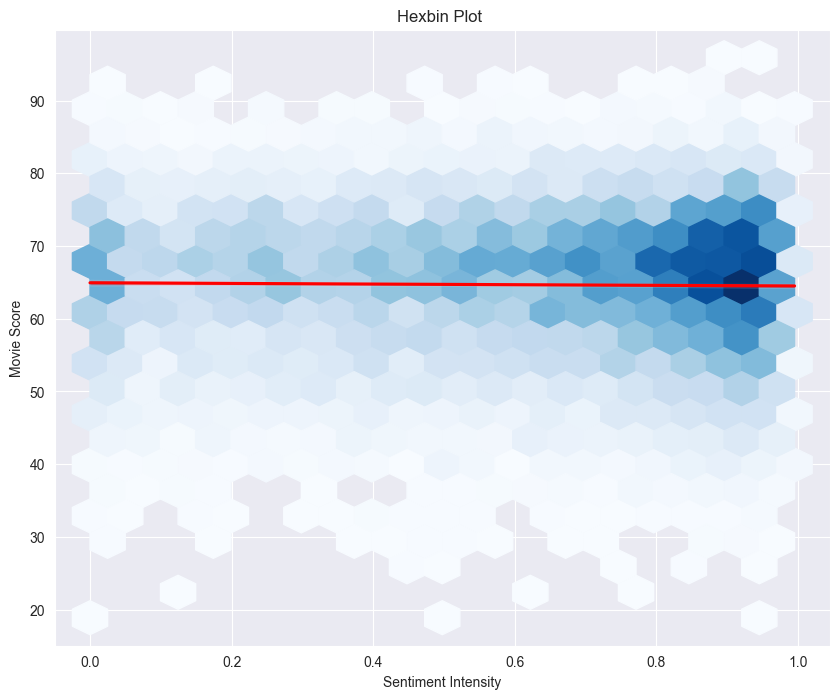

In [274]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
movies_with_genre = genres_and_sentiments[sentiments_cols]
movies_with_genre['sentiment_intensity'] = movies_with_genre['ending_compound_sentiment'].apply(np.abs)

ax.hexbin(movies_with_genre['sentiment_intensity'], movies_with_genre['movie_score'], gridsize=20, cmap='Blues', mincnt=1)
sns.regplot(movies_with_genre, x='sentiment_intensity', y='movie_score', scatter=False, ax=ax, color="red")
#slope, intercept, r_value, p_value, std_err = sts.linregress(movies_with_genre['sentiment_intensity'], movies_with_genre['movie_score'])
#line = slope * movies_with_genre['sentiment_intensity'] + intercept
#ax.plot(movies_with_genre['sentiment_intensity'], line, color='red')  # red line for the trend

ax.set_xlabel('Sentiment Intensity')
ax.set_ylabel('Movie Score')
ax.set_title(f'Hexbin Plot ')

In [257]:
import plotly

In [267]:
plotly.plot(data_frame=movies_with_genre, x='sentiment_intensity',y='movie_score',title='Density Heatmap of Movie Score vs Sentiment Intensity',
    xaxis_title='Sentiment Intensity',
    yaxis_title='Movie Score',
    kind='density_heatmap',
    width=700, 
    height=800)

TypeError: density_heatmap() got an unexpected keyword argument 'xaxis_title'